# B3_Create_and_Test_Model

This workbook **creates** and **test** the model. 

This entails the following steps:

| No.     | Step                                          |
| :-------| :---------------------------------------------|
| B3.1    | Import Libraries                              |
| B3.2    | Load Images                                   |
| B3.3    | Split Into Train and Test                     |
| B3.4    | Create Model                                  |
| B3.5    | Test Model                                    |

## B3.1 Import Libraries

In [1]:
#Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
import h5py
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model, optimizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## B3.2 Load Images

In [2]:
#Load images
data_dir = '../deepfashionextract2/img/'
categories = ['top', 'skirt', 'dress']

data = []

def create_data():
    
    for category in categories:
        path = os.path.join(data_dir, category)
        label = categories.index(category)

        for filename in os.listdir(path):
            #Load image
            img_data = os.path.join(path, filename)
            image = cv2.imread(img_data)
            
            try:
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                #Minimize to approx. one third
                image = cv2.resize(image, (96,96))
                image = np.array(image, dtype=np.float32)
                
                data.append([image, label])
            
            except Exception as e:
                pass
            
    print(len(data))
    
    #wb for write and binary
    pick = open('b_data.pickle', 'wb')
    pickle.dump(data, pick)
    pick.close()

In [3]:
create_data()

1500


In [4]:
def load_data():
    #rb for read and binary
    pick = open('b_data.pickle', 'rb')
    data = pickle.load(pick)
    pick.close()
    
    #Shuffle the data
    np.random.shuffle(data)
    
    feature = []
    labels = []
    
    for img, label in data:
        feature.append(img)
        labels.append(label)
        
    feature = np.array(feature, dtype=np.float32 )
    labels = np.array(labels)
        
    ##Normalize the pixels between 0 and 1
    feature = feature/255.0
    
    return [feature, labels]

In [5]:
load_data()

[array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[1.        , 1.        , 1.        ],
          [1.     

## B3.3 Split Into Train and Test

Since we do not have a large dataset only **10%** is saved for **test** so that more data can be used for training. 

In [6]:
#Unpack feature and labels
(feature, labels) = load_data()

In [7]:
#Divide into train and test
X_train, X_test, y_train, y_test = train_test_split(feature, labels, test_size=0.1)

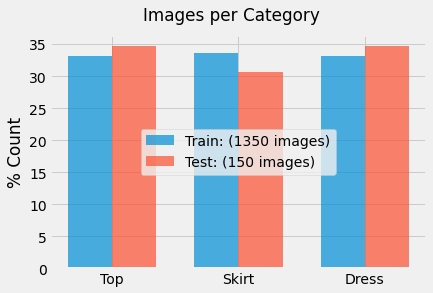

In [8]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
 
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
 
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% Count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
 
    xtemp = np.arange(len(unique))
 
    plt.style.use('fivethirtyeight')
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    labels = ['Top', 'Skirt', 'Dress']
    plt.xticks(xtemp, labels)
    plt.ylabel(ylabel_text)
    plt.suptitle('Images per Category')
    
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'Train: ({0} images)'.format(len(y_train)),
    'Test: ({0} images)'.format(len(y_test)), 
], loc=10);

## B3.4 Create Model

The model is created with **6 convolutional and pool layers and pools** to which the input sequentially passes.

Adjusting the hyperparameters, the following has proven to achieve an optimal result with the data at hand:

| No. | Findings                                                                         |
|:----|:---------------------------------------------------------------------------------|
| 1.  | 6 convolutional and pool layers rather than smaller and higher numbers of layers |
| 2.  | 96 filters rather than a mix of 32, 64 and 96 filters                            |
| 3.  | 512 neurons rather than 128 neurons                                              |
| 4.  | Adding a dropout layer                                                           |
| 5.  | A dropout layer of 70% rather than 50% or 90%                                    |
| 6.  | 15 epochs rather than 10, 12 or 20                                               |

It is important to note that at **15 epochs** already approx. **90% accuracy** of the training set is achieved. At 20 epochs the accuracy sinks again which may be due to **overfitting**. 

In [9]:
#Display categories for labels
categories = ['top', 'skirt', 'dress']

In [10]:
#Input is pixel and 3 indicating RGB
input_layer = tf.keras.layers.Input([96, 96, 3])

In [11]:
#From input_layer to conv_1
#Same padding means the size of the output feature maps are the same as the input feature maps.
conv_1 = tf.keras.layers.Conv2D(filters=96, kernel_size=(5,5), padding='same', activation='relu') (input_layer)

In [12]:
#From convolutional layer 1 to pool layer 1
pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

In [13]:
#From pool layer 1 to convolutional layer 2
conv_2 = tf.keras.layers.Conv2D(filters=96, kernel_size=(3,3), padding='same', activation='relu') (pool_1)

In [14]:
#Pool with strides
pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv_2)

In [15]:
#Increase of filters
conv_3 = tf.keras.layers.Conv2D(filters=96, kernel_size=(3,3), padding='same', activation='relu') (pool_2)

In [16]:
#Same like pool layer 2
pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv_3)

In [17]:
#Flatten
flt_1 = tf.keras.layers.Flatten()(pool_3)

In [18]:
#Dense layer with 512 neurons
dn_1 = tf.keras.layers.Dense(512, activation='relu')(flt_1)

In [19]:
dropout = tf.keras.layers.Dropout(0.7)(dn_1)

In [20]:
#Since 6 layers have been created, argument takes 6
out = tf.keras.layers.Dense(6, activation='softmax')(dropout)

In [21]:
#Create model - 1 
model = tf.keras.Model(input_layer, out)

In [22]:
#Create model - 2
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
#Fit model 
history = model.fit(X_train, y_train, batch_size=20, epochs=15)
history

Epoch 1/15
68/68 [==============================] - 23s 338ms/step - loss: 1.2193 - accuracy: 0.3452
Epoch 2/15
68/68 [==============================] - 24s 358ms/step - loss: 1.1167 - accuracy: 0.3733
Epoch 3/15
68/68 [==============================] - 26s 384ms/step - loss: 1.0517 - accuracy: 0.4519
Epoch 4/15
68/68 [==============================] - 26s 377ms/step - loss: 0.9942 - accuracy: 0.5089
Epoch 5/15
68/68 [==============================] - 26s 388ms/step - loss: 0.9336 - accuracy: 0.5467
Epoch 6/15
68/68 [==============================] - 26s 380ms/step - loss: 0.8593 - accuracy: 0.5896
Epoch 7/15
68/68 [==============================] - 26s 387ms/step - loss: 0.8241 - accuracy: 0.6215
Epoch 8/15
68/68 [==============================] - 25s 372ms/step - loss: 0.7443 - accuracy: 0.6637
Epoch 9/15
68/68 [==============================] - 26s 389ms/step - loss: 0.6512 - accuracy: 0.7267
Epoch 10/15
68/68 [==============================] - 26s 389ms/step - loss: 0.6135 - accura

The following shows a summary of the **hyperparameters**.

In [24]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 96)        7296      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 96)        83040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 96)        83040     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 96)       

In [25]:
#Save model
from keras.models import load_model
model.save('B_recognition.h5')

The test accuracy is approx. **65%**.

In [26]:
history2 = model.evaluate(X_test, y_test, verbose=1)
history2[1]

5/5 [==============================] - 1s 106ms/step - loss: 0.9821 - accuracy: 0.6533


0.653333306312561

In the sample below, the predictions of **three of nine** images are correct. As a side note, the images have a low resolution because after drastically resizing them, they cannot be restored to their original. 

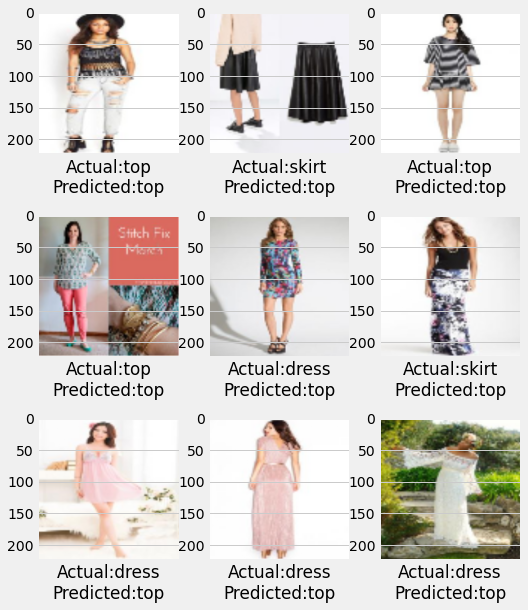

In [29]:
#Plot predictions
plt.figure(figsize=(6, 6))
plt.style.use('fivethirtyeight')
for i in range(9):
    plt.subplot(3,3,i+1)
    image = cv2.resize(X_test[i], (224, 224))
    plt.imshow(image)
    #np.argmax returns the position of the largest value
    plt.xlabel('Actual:'+categories[y_test[i]]+'\n'+'Predicted:'+categories[np.argmax(y_pred[i])])
    plt.xticks([])
    plt.subplots_adjust(left=None, bottom=None, right=1.2, top=1.4, wspace=None, hspace=None)

plt.show()

Other than the sample above might suggest, the **confusion matrix** shows that the model does not favor tops. Moreover, the majority of predictions is correct (see lighter blue diagonal).

In [27]:
#Confusion matrix
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
y_pred
cm = confusion_matrix(y_test, y_pred)
cm

array([[33,  6, 13],
       [ 6, 33,  7],
       [11,  9, 32]], dtype=int64)

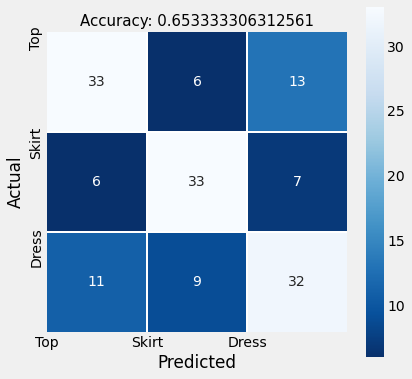

In [30]:
#Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot = True, linewidths=0.5, square=True, cmap='Blues_r')
plt.ylabel('Actual')
plt.xticks([0, 1, 2], ['Top', 'Skirt', 'Dress'])
plt.yticks([0, 1, 2], ['Top', 'Skirt', 'Dress'])
plt.xlabel('Predicted')
title='Accuracy: {0}'.format(history2[1])
plt.title(title, size=15)
plt.show()